<h1 style='text-align:center'>Krakow trams delays</h1>
<h4 style='text-align:center'>Dataset description (Polish language): https://aczepielik.github.io/post/kraktram/</h4>
<h4 style='text-align:center'>Dataset: https://github.com/aczepielik/KRKtram/tree/master/reports</h4><br><br>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR 
from sklearn.model_selection import cross_val_score

In [0]:
df1 = pd.read_csv('https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-23.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-24.csv')
df3 = pd.read_csv('https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-25.csv')
df4 = pd.read_csv('https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-26.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-27.csv')
df6 = pd.read_csv('https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-30.csv')
df7 = pd.read_csv('https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-31.csv')
trams = pd.concat([df1, df2, df3, df4, df5, df6, df7])

In [3]:
trams.head()

,index,time_stamp,stop,stopName,number,direction,plannedTime,vehicleId,tripId,status,delay,seq_num
0,1,2018-07-23 06:00:45,378,Os.Piastów,21,Kopiec Wandy,2018-07-23 05:59:00,NaN,6351558574044883205,PLANNED,1,1.0
1,1,2018-07-23 06:00:47,612,Borsucza,22,Walcownia,2018-07-23 06:00:00,6.352185e+18,6351558574044899587,STOPPING,0,7.0
2,1,2018-07-23 06:00:48,572,Smolki,11,Czerwone Maki P+R,2018-07-23 06:00:00,6.352185e+18,6351558574044670211,STOPPING,0,10.0
3,1,2018-07-23 06:00:49,319,Jubilat,1,Wzgórza K.,2018-07-23 05:59:00,NaN,6351558574044363010,PLANNED,1,3.0
4,1,2018-07-23 06:00:49,322,Filharmonia,8,Bronowice Małe,2018-07-23 06:01:00,6.352185e+18,6351558574044592386,STOPPING,0,15.0


In [4]:
# percentage distribution of delays 
# as you can see over 89% of all delays are in the range of 0-2 min
trams['delay'].value_counts(normalize=True)

0     0.426947
1     0.351028
2     0.116196
3     0.055438
4     0.026082
5     0.011961
6     0.005463
7     0.002969
8     0.001553
9     0.000989
10    0.000663
11    0.000315
12    0.000140
13    0.000133
14    0.000089
15    0.000022
16    0.000006
19    0.000004
18    0.000002
Name: delay, dtype: float64

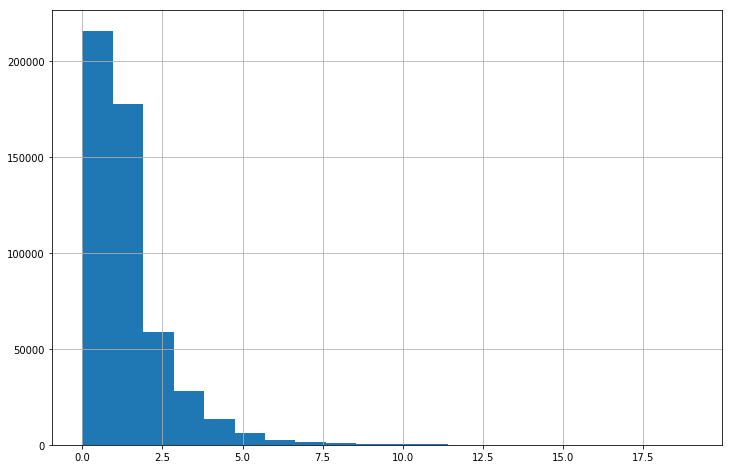

In [5]:
# delay distribution on the histogram
trams['delay'].hist(bins=20, figsize=(12,8));

<br><h2>FEATURE ENGINEERING</h2>

In [0]:
# transforming labels (delays) from minutes to seconds to make them more convenient for analysis
trams['delay_sec'] = trams['delay'].map(lambda x: x*60)

# factorization of text values into numerical values from the 'direction' column
trams['direction_num'] = trams['direction'].factorize()[0] 

# filling the missing values in the 'vehicleID' column with values that did not appear before (-1) 
# so as not to affect other records that have the given value
trams['vehicleId'].fillna(-1, inplace=True)
# same with column 'seq_num'
trams['seq_num'].fillna(-1, inplace=True)

In [0]:
# FEATURE SCALING
# Decision Tree and Random Forest do not require feature scaling, but other algorithms like SVM do not do well with non-standardized data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [8]:
# split data into features(X) and labels(y)
X = trams[['stop','number','direction_num','vehicleId','seq_num']]
y = trams['delay_sec'].values

model_tree = DecisionTreeRegressor(max_depth=10)
model_forest = RandomForestRegressor(max_depth=10, n_estimators=10)
model_svm = LinearSVR(C=1, epsilon=1)

# feature scaling
scaler.fit(X)
X_scaled = scaler.transform(X)

print('Decision Tree')
scores_tree = cross_val_score(model_tree, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_tree), 'STD:', np.std(scores_tree))

print('Random Forest')
scores_forest = cross_val_score(model_forest, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_forest), 'STD:', np.std(scores_forest))

print('SVM Regression')
scores_svm = cross_val_score(model_svm, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_svm), 'STD:', np.std(scores_svm))

Decision Tree
MAE:  -47.010324336141444 STD: 0.4768498864422201
Random Forest
MAE:  -46.691584323943836 STD: 0.5297267271838026
SVM Regression
MAE:  -51.37996441997783 STD: 0.13799648530255046


<b>Adding new features:</b>

In [0]:
# creating a new feature by connecting the tram number (col 'number') and the direction in which the tram is going (col 'direction')
def id_tram_direction(x):
    return '{} {}'.format(x['number'], x['direction']) 
trams['tram_direction_id'] = trams.apply(id_tram_direction, axis=1).factorize()[0]

# the same for the stop number (col 'stop') and the direction in which the tram is going (col 'direction')
def id_stop_direction(x):
    return '{} {}'.format(x['stop'], x['direction']) 
trams['stop_direction_id'] = trams.apply(id_tram_direction, axis=1).factorize()[0]

X = trams[['stop','number','direction_num','vehicleId','seq_num','tram_direction_id','stop_direction_id']].values

# feature scaling
scaler.fit(X)
X_scaled = scaler.transform(X)

print('Decision Tree')
scores_tree = cross_val_score(model_tree, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_tree), 'STD:', np.std(scores_tree))

print('Random Forest')
scores_forest = cross_val_score(model_forest, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_forest), 'STD:', np.std(scores_forest))

print('SVM Regression')
scores_svm = cross_val_score(model_svm, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_svm), 'STD:', np.std(scores_svm))

Decision Tree
MAE:  -47.058051291615534 STD: 0.7007041110911034
Random Forest
MAE:  -46.66650997316095 STD: 0.64653830358904
SVM Regression
MAE:  -51.34708832416826 STD: 0.11709988929335784


<b>As you can see, the new features caused a slight improvement in MAE for RandomForest and SVM Regression. However, the standard deviation for Decision Tree and Random Forest has increased significantly, so I decided that the new features don't give any noticeable benefits, so I removed it.</b>

In [0]:
trams.drop(['tram_direction_id','stop_direction_id'], axis=1, inplace=True)

<b>Now I try to experiment a little with the date and time column (plannedTime) to find the correlation between time of day and trams delay. It can be expected that during peak hours tram delays will be greater due to increased traffic in the city. This feature should improve the efficiency of the model.</b>

In [0]:
# mapping string to date format
trams['plannedTime'] = pd.to_datetime(trams['plannedTime'])

In [0]:
# extracting the time (hour) from the date
trams['tram_hour'] = trams['plannedTime'].dt.hour

In [11]:
X = trams[['stop','number','direction_num','vehicleId','seq_num','tram_hour']].values

# feature scaling
scaler.fit(X)
X_scaled = scaler.transform(X)

print('Decision Tree')
scores_tree = cross_val_score(model_tree, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_tree), 'STD:', np.std(scores_tree))

print('Random Forest')
scores_forest = cross_val_score(model_forest, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_forest), 'STD:', np.std(scores_forest))

print('SVM Regression')
scores_svm = cross_val_score(model_svm, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(scores_svm), 'STD:', np.std(scores_svm))

Decision Tree
MAE:  -46.846746650109964 STD: 0.5140000220730191
Random Forest
MAE:  -46.289616467993774 STD: 0.5916825725738786
SVM Regression
MAE:  -51.36283913915248 STD: 0.1303087717459281


<b>New feature slightly improve model efficiency, so its addition was the right step.</b>

<br><br><h1 style='text-align:center'>Model tuning</h1>
<h4 style='text-align:center'><b>Random Forest performs best so I take it to further hyperparameters tune by random search method.</b></h4>

In [12]:
from pprint import pprint # show parameters used by model
pprint(model_forest.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [0]:
from sklearn.model_selection import RandomizedSearchCV

max_depth = [4, 8, 10, 16]
n_estimators = [4, 10, 50, 100]
min_samples_split = [2, 4, 8, 12]
min_samples_leaf = [2, 4, 8, 12]

param_grid = {
     'max_depth': max_depth,
     'n_estimators': n_estimators,
     'min_samples_split': min_samples_split, 
     'min_samples_leaf': min_samples_leaf
}

model = RandomForestRegressor()

forest_random_search = RandomizedSearchCV(
       estimator=model, 
       param_distributions=param_grid,
       n_iter = 100, 
       scoring='neg_mean_absolute_error', 
       cv = 3, 
       random_state=42, 
       return_train_score=True
)

In [14]:
X = trams[['stop','number','direction_num','vehicleId','seq_num','tram_hour']]
scaler.fit(X)
X_scaled = scaler.transform(X)

y = trams['delay_sec']

forest_random_search.fit(X_scaled, y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [15]:
forest_random_search.best_params_

{'max_depth': 16,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [17]:
# creating and testing model with the best parameters
best_model = forest_random_search.best_estimator_

print('Best results Random Forest:')
best_scores_forest = cross_val_score(best_model, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
print('MAE: ', np.mean(best_scores_forest), 'STD:', np.std(best_scores_forest))

Best results Random Forest:
MAE:  -43.93498799144002 STD: 0.5721118660333777


<h3 style='text-align:center;'>Tuned model show MAE improvement by 2.36 sec and STD by 0.02 sec. <br>In summary, the model performs quite well. The 43 second prediction error is acceptable for tram passengers.</h3><br><br>